# Pipelines, grid search i text mining

### Nivell 1
#### Exercici 1
Agafa el conjunt de dades que vulguis i realitza un pipeline i un gridsearch aplicant l'algorisme de Random Forest.

In [452]:
import pandas as pd
from sklearn.compose import ColumnTransformer
import numpy as np 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,plot_confusion_matrix
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from textblob import TextBlob
from imblearn.over_sampling import SMOTE
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.sentiment.vader import SentimentIntensityAnalyzer


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\adria\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [453]:
test = pd.read_csv('tested.csv')
train = pd.read_csv('train.csv')

In [454]:
df = pd.concat([train,test],axis=0)
df.reset_index(inplace=True, drop=True) 

**Explore the  dataset**

In [455]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,0,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,1,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,0,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,0,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [456]:
df.isna().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

**Data cleaning and imputation of missing values**

In [457]:
## drop umnecessary features
df.drop(['Name','Ticket','Cabin'],axis=1,inplace=True)

In [458]:
for feature in df:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

In [459]:
df.drop(['SibSp','Parch'],axis=1,inplace=True)


In [460]:
group = df.groupby(['Pclass','Sex'])['Age'].median().reset_index(name = 'AgeMedian')
group

,Pclass,Sex,AgeMedian
0,1,female,36.0
1,1,male,42.0
2,2,female,28.0
3,2,male,29.5
4,3,female,22.0
5,3,male,25.0


imputation of Age nan values  with specific range  of class and sex

In [461]:
for r,c in df.loc[df.Age.isnull()].iterrows():
    if((c['Pclass']==1) & (c['Sex']=='female')):
        
        df.loc[r,'Age']=group['AgeMedian'][0]
    elif ((c['Pclass']==1) & (c['Sex']=='male')):
        
        df.loc[r,'Age']=group['AgeMedian'][1]
    elif ((c['Pclass']==2) & (c['Sex']=='female')):
        
        df.loc[r,'Age']=group['AgeMedian'][2]
    elif ((c['Pclass']==2) & (c['Sex']=='male')):
        
        df.loc[r,'Age']=group['AgeMedian'][3]
    elif ((c['Pclass']==3) & (c['Sex']=='female')):
        
        df.loc[r,'Age']=group['AgeMedian'][4]
    elif ((c['Pclass']==3) & (c['Sex']=='male')):
        
        
        df.loc[r,'Age']=group['AgeMedian'][5]

fill embarked nan values with the most repeated value

In [462]:
df['Embarked'].fillna(df['Embarked'].mode()[0],inplace=True)

In [463]:
groupfare = df.groupby(['Pclass'])['Fare'].median().reset_index(name = 'FareMedian')
groupfare

,Pclass,FareMedian
0,1,60.0000
1,2,15.0458
2,3,8.0500


In [464]:
df.loc[df.Fare.isnull()]

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize
1043,1044,0,3,male,60.5,NaN,S,1


fill fare nan value  with the fare median of  people of class 3

In [465]:
df.loc[df.Fare.isnull(),'Fare']=groupfare['FareMedian'][2]

In [466]:
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
Fare           0
Embarked       0
FamilySize     0
dtype: int64

**Pipeline,StandardScale and model performance**

In [467]:
X = df.drop('Survived',axis=1)
y = df.iloc[:,1]

In [468]:
numeric_columns = ['PassengerId','Fare','Age']
category_columns = ['Pclass','Sex','Embarked','FamilySize']

trought ColumTranformer we  can choose specific transformation for diferents data types

In [469]:
processer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), category_columns),('num',StandardScaler(),numeric_columns)])
                                                                                        

Implementation of a Pipeline that would group  data transformation and ML model  in a chain

In [470]:
pipe = Pipeline([('t',processer),('Random_Forest',RF())])
param_grid = { 
    'Random_Forest__n_estimators': [200, 500],
    'Random_Forest__max_features': ['auto', 'sqrt', 'log2'],
    'Random_Forest__max_depth' : [4,5,6,7,8],
    'Random_Forest__criterion' :['gini', 'entropy']
}
                

In [471]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)


In [472]:
pipe.fit(X_train, np.array(y_train))

Pipeline(steps=[('t',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['Pclass', 'Sex', 'Embarked',
                                                   'FamilySize']),
                                                 ('num', StandardScaler(),
                                                  ['PassengerId', 'Fare',
                                                   'Age'])])),
                ('Random_Forest', RandomForestClassifier())])

after the fitting and before implement  GridSearch we can observe the metrics  of the pipeline implementation


In [473]:
cf_matrix =confusion_matrix(y_test,y_pipe_predict)
def Confusion_matrix(cf_matrix):
    plt.subplots(figsize=(10, 5))
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
    plt.title('Confusion Matrix')

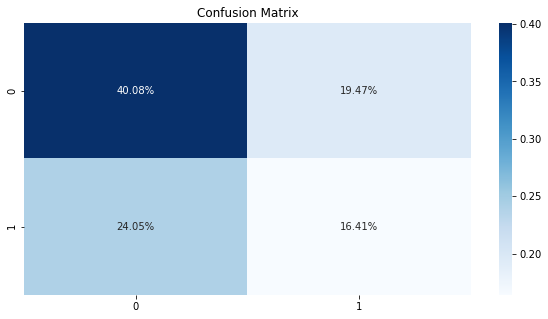

In [474]:
cf_matrix =confusion_matrix(y_test,y_pipe_predict)
Confusion_matrix(cf_matrix)

In [475]:
print(classification_report(y_test,y_pipe_predict))

              precision    recall  f1-score   support

           0       0.62      0.67      0.65       156
           1       0.46      0.41      0.43       106

    accuracy                           0.56       262
   macro avg       0.54      0.54      0.54       262
weighted avg       0.56      0.56      0.56       262



now  in order to find the best estimators of the model i will use GridSearchCV

In [476]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)


In [477]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('t',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(),
                                                                         ['Pclass',
                                                                          'Sex',
                                                                          'Embarked',
                                                                          'FamilySize']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['PassengerId',
                                                                          'Fare',
                                                                          'Age'])])

In [478]:
grid.best_params_

{'Random_Forest__criterion': 'gini',
 'Random_Forest__max_depth': 7,
 'Random_Forest__max_features': 'sqrt',
 'Random_Forest__n_estimators': 500}

we fit  the model with the best parameters of  gridsearchcv

In [479]:
best_grid = grid.best_estimator_
best_grid.fit(X_train,y_train)

predict_train = best_grid.predict(X_train)
predict_test = best_grid.predict(X_test)

In [480]:
print(classification_report(y_test,predict_test))

              precision    recall  f1-score   support

           0       0.87      0.92      0.90       156
           1       0.88      0.80      0.84       106

    accuracy                           0.87       262
   macro avg       0.87      0.86      0.87       262
weighted avg       0.87      0.87      0.87       262



In [481]:
c2_matrix =confusion_matrix(y_test,predict_test)


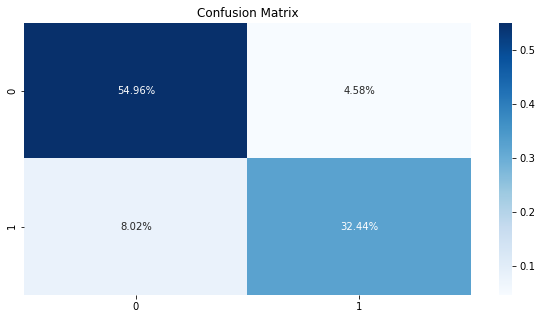

In [482]:
Confusion_matrix(c2_matrix)

We will plot the features importance

In [483]:
onehot_columns = pipe.named_steps['t'].named_transformers_['cat'].get_feature_names(input_features=category_columns)


In [484]:
grid.best_estimator_._final_estimator.feature_importances_

array([0.02545638, 0.01017996, 0.03788571, 0.28790486, 0.30809982,
       0.00687683, 0.00570783, 0.01005522, 0.01517094, 0.00755749,
       0.00852044, 0.0074571 , 0.00650965, 0.00412393, 0.00217863,
       0.00132273, 0.00314284, 0.08990514, 0.09227427, 0.06967024])

In [485]:
feature_importance=pd.Series(grid.best_estimator_._final_estimator.feature_importances_, index=list(onehot_columns) + numeric_columns  )

In [486]:
feature_importance=feature_importance.sort_values(ascending=False)

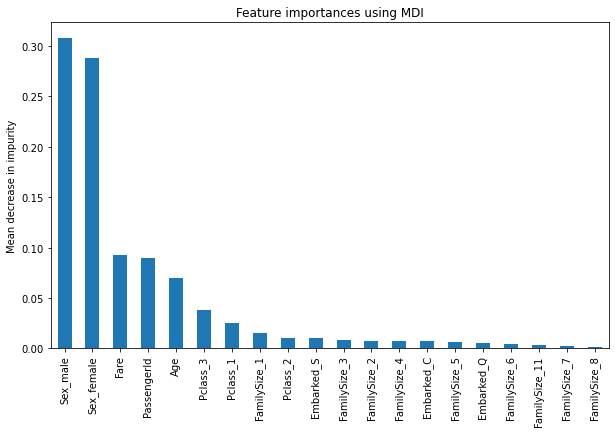

In [490]:
plt.figure(figsize=(10, 6))

feature_importance.plot.bar()

plt.title("Feature importances using MDI")
plt.ylabel("Mean decrease in impurity")
fig.tight_layout()

## Exercici 2
Agafa un text en anglès que vulguis, i calcula'n la freqüència de les paraules

we choose as a text  to analyze  the popular song  Imagine of jhonn lennon , we chose that song because is 
a well known song that as a humans we percieved very positive and it would be interesing how the algorithm perceive that kind of metaphoric  text

In [509]:
f = open('imagine.txt','r')

In [492]:
content = f.read()

After load the text first  we have to split  the text into tuples of words

In [510]:
tokenizer = nltk.RegexpTokenizer(r"\w+")
tokenized_word=tokenizer.tokenize(content)

Before any  proccesing  we can plot the 10 most common words in the text

In [512]:
fdist = FreqDist(tokenized_word).most_common(10)
print(fdist)

[('the', 8), ('I', 7), ('Imagine', 6), ('no', 4), ('you', 4), ('us', 4), ('all', 4), ('You', 4), ('m', 4), ('one', 4)]


<AxesSubplot:>

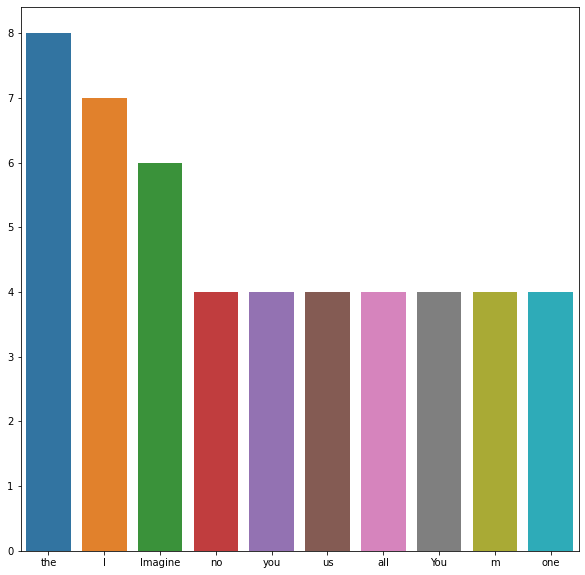

In [513]:

fdist = pd.Series(dict(fdist))
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x=fdist.index, y=fdist.values,ax=ax)

as  expected  almost all the common words  come from articles or pronouns

## Nivell 2
### Exercici 1
Treu les stopwords i realitza stemming al teu conjunt de dades.

in order to clean and  find important content or valid frequency  distribtuion first we will remove all the stopswords 

In [515]:

stop_words=set(stopwords.words("english"))
print(stop_words)

{'whom', 'the', 'aren', 'them', "didn't", 'off', 'down', 'those', 'there', 'an', 'nor', 'at', 'because', 'as', 'all', 'how', 'being', 'its', 'doing', 'while', 'my', 'once', 'few', 'they', 'than', 'before', 'o', "couldn't", 'and', 're', 'll', "mightn't", "she's", 'for', 'some', 'doesn', "doesn't", "it's", 'are', 'further', 've', 'such', 'haven', 'couldn', 'about', 'each', 'so', "wasn't", 'itself', 'their', 'have', 'ours', 'your', 'but', 'that', 'not', 'no', 'weren', 'did', 'wouldn', 'had', 'y', "isn't", 'isn', 'needn', 'until', "hadn't", 'be', "don't", 'hadn', 'herself', "aren't", 'most', 'out', 'm', 'can', 'she', 'by', 'theirs', 'do', 'or', 'only', "mustn't", 'to', 'didn', 'again', 'who', 's', "you'd", 'just', 't', 'themselves', 'other', 'don', 'should', 'hers', 'wasn', 'it', "needn't", 'these', 'up', 'shouldn', "you've", 'which', "hasn't", 'him', 'was', "that'll", 'why', 'were', 'with', 'ain', "haven't", "you'll", 'ourselves', 'of', 'a', 'when', 'will', 'from', 'yourself', 'has', 'doe

In [516]:
filtered_sent=[]
for w in tokenized_word:
    if w not in stop_words:
        filtered_sent.append(w)

print("Filterd Sentence:",filtered_sent)

Filterd Sentence: ['Imagine', 'heaven', 'It', 'easy', 'try', 'No', 'hell', 'us', 'Above', 'us', 'sky', 'Imagine', 'people', 'Livin', 'today', 'Ah', 'Imagine', 'countries', 'It', 'hard', 'Nothing', 'kill', 'die', 'And', 'religion', 'Imagine', 'people', 'Livin', 'life', 'peace', 'You', 'You', 'may', 'say', 'I', 'dreamer', 'But', 'I', 'one', 'I', 'hope', 'someday', 'join', 'us', 'And', 'world', 'one', 'Imagine', 'possessions', 'I', 'wonder', 'No', 'need', 'greed', 'hunger', 'A', 'brotherhood', 'man', 'Imagine', 'people', 'Sharing', 'world', 'You', 'You', 'may', 'say', 'I', 'dreamer', 'But', 'I', 'one', 'I', 'hope', 'someday', 'join', 'us', 'And', 'world', 'live', 'one']


now  we can  do another plot of frequency distribution with more acuraccy

<AxesSubplot:>

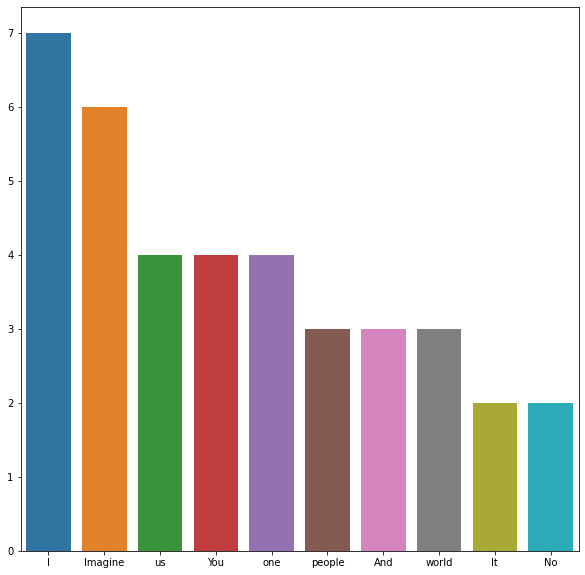

In [521]:
fdist_filtered = FreqDist(filtered_sent).most_common(10)
fdist_filtered= pd.Series(dict(fdist_filtered))
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x=fdist_filtered.index, y=fdist_filtered.values,ax=ax)

now we can extract the root word of any articulated form of a word with Stemmer

In [523]:
ps = PorterStemmer()
stemmed_text =[]
for w in filtered_sent:
    stemmed_text.append(ps.stem(w))
print(stemmed_text)

['imagin', 'heaven', 'It', 'easi', 'tri', 'No', 'hell', 'us', 'abov', 'us', 'sky', 'imagin', 'peopl', 'livin', 'today', 'Ah', 'imagin', 'countri', 'It', 'hard', 'noth', 'kill', 'die', 'and', 'religion', 'imagin', 'peopl', 'livin', 'life', 'peac', 'you', 'you', 'may', 'say', 'I', 'dreamer', 'but', 'I', 'one', 'I', 'hope', 'someday', 'join', 'us', 'and', 'world', 'one', 'imagin', 'possess', 'I', 'wonder', 'No', 'need', 'greed', 'hunger', 'A', 'brotherhood', 'man', 'imagin', 'peopl', 'share', 'world', 'you', 'you', 'may', 'say', 'I', 'dreamer', 'but', 'I', 'one', 'I', 'hope', 'someday', 'join', 'us', 'and', 'world', 'live', 'one']


## Nivell 3
### Exercici 1
Realitza sentiment analysis al teu conjunt de dades.

we will use two methods for sentiment analysis 
- TextBlob
- SenSentimentIntensityAnalyzer

In [524]:
word_string =' '.join(filtered_sent)

In [525]:
## using TextBlob
book_sent = TextBlob(word_string)


Sentiment(polarity=0.06950757575757575, subjectivity=0.49375)

the sentiment function of textblob returns two properties, polarity, and subjectivity.

Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1].

In [528]:
book_sent.sentiment

Sentiment(polarity=0.06950757575757575, subjectivity=0.49375)

the results shows that the polarity is  close to 0 and subjectivy of 0.49 meaning that there's not clear perception of postivie or negative  of the text . that make sense since the choosen text is a song that normaly implies subjective concepts

In [526]:
### using SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(word_string)


{'neg': 0.15, 'neu': 0.556, 'pos': 0.294, 'compound': 0.938}

The  function return 5 variables: 
- neg = negative,neu=neutral
- pos=positive  
- compound.


The compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive).
positive sentiment : (compound score >= 0.05) 
neutral sentiment : (compound score > -0.05) and (compound score < 0.05) 
negative sentiment : (compound score <= -0.05)
 


the results shows that the higher metric is compound with  0.93 meaning that the texts is mostly possitive followed by a neutral score of 0.55 
as the previous analysis  the neutral score could be due the fact that  with artistics text  even though as humans we can percive quickly that the texts represents a positive sentiments  the algorithm cannot undersand complex and figurative concepcts 

***WordCloud***

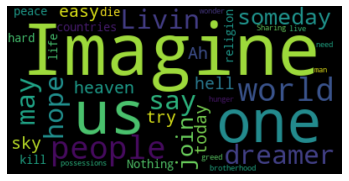

In [531]:

wordcloud = WordCloud().generate(word_string)


plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()